# HuggingFace API Login

In [144]:
from huggingface_hub import notebook_login

notebook_login()

# Libraries & Packages Management :

## Download Packages

In [145]:
!pip install datasets
!pip install torchsummary
!pip install torchinfo
!pip install evaluate
!pip install seqeval

## Import Libraries :

In [146]:
# essential libraries
import pandas as pd
import numpy as np
import warnings
import re
import json
import os


# spacy libararies
import spacy
from spacy.tokens import Doc
from spacy.tokenizer import Tokenizer


# modelling libraries
from transformers import DistilBertTokenizer,DistilBertForTokenClassification, BertTokenizer
from transformers import Trainer, TrainingArguments ,EarlyStoppingCallback ,pipeline
from sklearn.model_selection import train_test_split
from datasets import Dataset,DatasetDict,load_metric


# from-scratch modelling libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# evaluation libraires
import evaluate
from seqeval.metrics import classification_report

# plotting libraries
import matplotlib.pyplot as plt
from torchinfo import summary
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer


# ignoring warnings
warnings.filterwarnings("ignore")

# Transforming dataset :

In [147]:
csv = "/content/drive/MyDrive/UH - Final Year Project/data/df-iter-1.csv"
df = pd.read_csv(csv)
df

,sentence,vars,names,variable_position
0,The loading term becomes relevant at a time τ,['τ'],a time,['end']
1,we get easily for the rupture force f ∗,['f'],the rupture force,['end']
2,Green’s theorem can be used to show that the v...,['d3xG(x)'],the volume,['end']
3,at a ﬁxed point x,['x'],['point'],['end']
4,it will be quite small (|K| is large) around t...,['x'],the point,['end']
...,...,...,...,...
296,we are inspired by the recent advances in the ...,['(information)'],quantum,['end']
297,"then the correlation function C(A, B)","['C(A, B)']",the correlation function,['end']
298,Next is to utilize the perturbation expansion ...,['f'],the longitudinal distribution function,['end']
299,the resonator voltage V f,['V'],the resonator voltage,['end']


In [148]:
 # drop unecessary "[]" inside names
df["names"] = df["names"].apply(lambda name: name.strip("[]'"))
df['vars'] = df['vars'].apply(lambda x: x.strip("[]'"))
df.drop(columns=["variable_position"],inplace=True)

In [149]:
def preprocessing(dataframe) :
  df = dataframe.drop_duplicates()
  df["names"] = df["names"].apply(lambda name: name.strip("[]'"))
  df['vars'] = df['vars'].apply(lambda x: x.strip("[]'"))
  df.drop(columns=["variable_position"],inplace=True)

  return df

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  301 non-null    object
 1   vars      301 non-null    object
 2   names     301 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [151]:
df

,sentence,vars,names
0,The loading term becomes relevant at a time τ,τ,a time
1,we get easily for the rupture force f ∗,f,the rupture force
2,Green’s theorem can be used to show that the v...,d3xG(x),the volume
3,at a ﬁxed point x,x,point
4,it will be quite small (|K| is large) around t...,x,the point
...,...,...,...
296,we are inspired by the recent advances in the ...,(information),quantum
297,"then the correlation function C(A, B)","C(A, B)",the correlation function
298,Next is to utilize the perturbation expansion ...,f,the longitudinal distribution function
299,the resonator voltage V f,V,the resonator voltage


# Sentence Tokenization :

In [152]:
global added_tokens
added_tokens = []

In [153]:
def my_custom_tokenizer(text,func_tokens=False) :

  # defining function pattern
  func_name = r"α-ωA-Za-zΑ-Ω0-9ℰℓℒℳøℂℕℙℚℝℤΓΔΛΞΠΣΦΨΩÅℏ∞∘∂∫∮∯∇αβγ∅"
  func_var = r"A-Za-zα-ωΑ-ΩℰℓℒℳøℂℕℙℚℝℤΓΔΛΞΠΣΦΨΩÅℏ∞∘∂∫∮∯∇αβγ∅"
  func_pattern = fr"(.|)([{func_name}]{{1,3}}(′|.|)\([{func_var}](,\s*[{func_var}])*\))"

  # getting math functions
  matches = re.findall(func_pattern, text)

  # getting only second-group matches (the functions)
  functions = [match[1] for match in matches]
  func_saver = iter(functions.copy())
  global added_tokens


  # Replace math functions with temporary markers
  for func in functions:
    text = text.replace(func, "[FUNC]")
    # adding the function to the gloabl variable
    if func_tokens :
      added_tokens.append(func)

  # Tokenize the rest of the text
  tokens = text.split()

  # Replace temporary markers with original functions
  new_tokens = [next(func_saver) if '[FUNC]' in token else token for token in tokens]

  return new_tokens

In [154]:
def create_spacy_tokenizer(nlp):
    def custom_tokenizer(text):
        tokens = my_custom_tokenizer(text,True)
        return Doc(nlp.vocab, words=tokens)
    return custom_tokenizer

In [155]:
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = create_spacy_tokenizer(nlp)

In [156]:
def tokenize(text) :
  # defining tokens list
  tokens= []
  doc = nlp(text)

  # Iterating over tokens
  for token in doc:
    tokens.append(str(token))
  return tokens

In [157]:
# this returns tokens inside the list
global added_tokens
added_tokens = []
df['tokenized_sentence'] = df['sentence'].apply(tokenize)

In [158]:
print(added_tokens)

['d3xG(x)', 'H(x)', 'U(x)', 'U (b)', 'U(x)', 'S(x)', 'S(x)', 'φ(ρ)', 'δχ (z)', 'r(t)', 'r(t)', 'M(t)', 'GT (y)', 'fmc(r)', 'fmc(r)', 'Φs(r)', 'GT (y)', 'V (t)', 'ψ0(t)', 'b0n(ω)', 'V (t)', 'GT (y)', 'V (t)', 'ψ0(t)', 'b0n(ω)', 'V (t)', 'λ(x)', 'f (p, t)', 'T (p, x)', '1(p, x)', 'ρ(x, t)', 'ψ(x, t)', 'ψ(x, t)', 'ρ(x, t)', 'ψp(x, t)', 'ρ(x, t)', 'ρ(x, t)', 'dψ(x, t)', 'ρ(x,t)', 'x(t)', 'E1(ρ)', 'erf(z)', 'f (p, t)', 'T (p, x)', '1(p, x)', 'ρ(x, t)', 'ψ(x, t)', 'ψ(x, t)', 'ρ(x, t)', 'ψp(x, t)', 'ρ(x, t)', 'ρ(x, t)', 'dψ(x, t)', 'ρ(x,t)', 'x(t)', 'f(x)', 'V(R)', 'V(R)', 'V12 (R)', 'W(R)', 'f(R)', 'f(R)', 'R(Å)', 'P3(t)', 'P3(t)', 'ing (x, y, z, t)', 'ing (x, y, z, t)', 'Z(k)', 'Z2(k)', 'Z(k)', 'ψT(R)', 'O(N)', 'Ak(t)', 'B0(x)', 'S(ζ)', 'R(ξ, t)', 'G(z)', 'Gi(z)', 'C(A, B)']


In [159]:
mathematical_symbols = [
    'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω',
    'Α', 'Β', 'Γ', 'Δ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι', 'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Ρ', 'Σ', 'Τ', 'Υ', 'Φ', 'Χ', 'Ψ', 'Ω',
    'ℰ', 'ℓ', 'ℒ', 'ℳ', 'ø', 'ℂ', 'ℕ', 'ℙ', 'ℚ', 'ℝ', 'ℤ','Γ', 'Δ', 'Λ', 'Ξ', 'Π', 'Φ', 'Ψ', 'Ω','Å', 'ℏ', '∞',
    '∂', '∮', '∯', '∇','∅','˜','µ','ǫ','ℋ', 'ℨ', 'ℛ']

mathematical_operations = ['∫', '∑', '∏', '√', '+', '-', '*', '/', '=', '^', '%','∩', '∪', '⊂', '⊆', '∈', '∉','∘' , "≡","<",">","↔","|"]

added_tokens = added_tokens + mathematical_symbols +  mathematical_operations

In [160]:
print(added_tokens)

['d3xG(x)', 'H(x)', 'U(x)', 'U (b)', 'U(x)', 'S(x)', 'S(x)', 'φ(ρ)', 'δχ (z)', 'r(t)', 'r(t)', 'M(t)', 'GT (y)', 'fmc(r)', 'fmc(r)', 'Φs(r)', 'GT (y)', 'V (t)', 'ψ0(t)', 'b0n(ω)', 'V (t)', 'GT (y)', 'V (t)', 'ψ0(t)', 'b0n(ω)', 'V (t)', 'λ(x)', 'f (p, t)', 'T (p, x)', '1(p, x)', 'ρ(x, t)', 'ψ(x, t)', 'ψ(x, t)', 'ρ(x, t)', 'ψp(x, t)', 'ρ(x, t)', 'ρ(x, t)', 'dψ(x, t)', 'ρ(x,t)', 'x(t)', 'E1(ρ)', 'erf(z)', 'f (p, t)', 'T (p, x)', '1(p, x)', 'ρ(x, t)', 'ψ(x, t)', 'ψ(x, t)', 'ρ(x, t)', 'ψp(x, t)', 'ρ(x, t)', 'ρ(x, t)', 'dψ(x, t)', 'ρ(x,t)', 'x(t)', 'f(x)', 'V(R)', 'V(R)', 'V12 (R)', 'W(R)', 'f(R)', 'f(R)', 'R(Å)', 'P3(t)', 'P3(t)', 'ing (x, y, z, t)', 'ing (x, y, z, t)', 'Z(k)', 'Z2(k)', 'Z(k)', 'ψT(R)', 'O(N)', 'Ak(t)', 'B0(x)', 'S(ζ)', 'R(ξ, t)', 'G(z)', 'Gi(z)', 'C(A, B)', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'Α', 'Β', 'Γ', 'Δ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι', 'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Ρ', 'Σ', 'Τ', 'Υ',

In [161]:
df.head()

,sentence,vars,names,tokenized_sentence
0,The loading term becomes relevant at a time τ,τ,a time,"[The, loading, term, becomes, relevant, at, a,..."
1,we get easily for the rupture force f ∗,f,the rupture force,"[we, get, easily, for, the, rupture, force, f, ∗]"
2,Green’s theorem can be used to show that the v...,d3xG(x),the volume,"[Green’s, theorem, can, be, used, to, show, th..."
3,at a ﬁxed point x,x,point,"[at, a, ﬁxed, point, x]"
4,it will be quite small (|K| is large) around t...,x,the point,"[it, will, be, quite, small, (|K|, is, large),..."


# Labelling :

In [162]:
sentence = ["The","quick","brown","fox" ,"jumps" ,"over","the","lazy","dog"]
word = "The quick brown fox"
word_tokened = word.split()
start = sentence.index(word_tokened[0])
end = sentence.index(word_tokened[-1])

for i in range(start,end+1) :
  if i == start :
    sentence[i] = "B-NAME"
  else :
    sentence[i] = "I-NAME"

In [163]:
def labeling(dataframe):
  labz = []
  for var , name , tokenized_sents in zip(dataframe["vars"],dataframe["names"],dataframe["tokenized_sentence"]) :
    # initilaising everything as oustide of entity
    labels = ['O']*len(tokenized_sents)
    # anonattating variable name
    if var in tokenized_sents :
      idx = tokenized_sents.index(var)
      labels[idx] = "B-VAR"

    tokenized_name = name.split()
    # dealing with names :
    if len(tokenized_name) > 1 :
      if tokenized_name[0] in  tokenized_sents :
        # getting name start index
        start_idx = tokenized_sents.index(tokenized_name[0])
        # getting name end index
        end_idx = tokenized_sents.index(tokenized_name[-1])

        # looping over the labels :
        for i in range(start_idx,end_idx+1) :
          if i == start_idx :
            labels[i] = "B-NAME"
          else :
            labels[i] = "I-NAME"
    elif len(tokenized_name) == 1 :
      if tokenized_name in tokenized_sents :
        idx = tokenized_sents.index(tokenized_name)
        labels[i] = "B-NAME"
    labz.append(labels)
  return labz

In [164]:
df["labels"] = labeling(df)
df

,sentence,vars,names,tokenized_sentence,labels
0,The loading term becomes relevant at a time τ,τ,a time,"[The, loading, term, becomes, relevant, at, a,...","[O, O, O, O, O, O, B-NAME, I-NAME, B-VAR]"
1,we get easily for the rupture force f ∗,f,the rupture force,"[we, get, easily, for, the, rupture, force, f, ∗]","[O, O, O, O, B-NAME, I-NAME, I-NAME, B-VAR, O]"
2,Green’s theorem can be used to show that the v...,d3xG(x),the volume,"[Green’s, theorem, can, be, used, to, show, th...","[O, O, O, O, O, O, O, O, B-NAME, I-NAME, O, O,..."
3,at a ﬁxed point x,x,point,"[at, a, ﬁxed, point, x]","[O, O, O, O, B-VAR]"
4,it will be quite small (|K| is large) around t...,x,the point,"[it, will, be, quite, small, (|K|, is, large),...","[O, O, O, O, O, O, O, O, O, B-NAME, I-NAME, B-..."
...,...,...,...,...,...
296,we are inspired by the recent advances in the ...,(information),quantum,"[we, are, inspired, by, the, recent, advances,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-VAR, O]"
297,"then the correlation function C(A, B)","C(A, B)",the correlation function,"[then, the, correlation, function, C(A, B)]","[O, B-NAME, I-NAME, I-NAME, B-VAR]"
298,Next is to utilize the perturbation expansion ...,f,the longitudinal distribution function,"[Next, is, to, utilize, the, perturbation, exp...","[O, O, O, O, B-NAME, I-NAME, I-NAME, I-NAME, I..."
299,the resonator voltage V f,V,the resonator voltage,"[the, resonator, voltage, V, f]","[B-NAME, I-NAME, I-NAME, B-VAR, O]"


In [165]:
df["labels"][1]

['O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'B-VAR', 'O']

# Fintuning model :

## Data Encoding

In [166]:
class CustomDistilBertTokenizer(DistilBertTokenizer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def tokenize(self, text, **kwargs):
        return my_custom_tokenizer(text)

In [167]:
def vocab_stats(model,tokenizer) :
  print(f"Tokenizer vocabulary size  : {len(tokenizer)}")
  print(f"Model embedding size : {model.get_input_embeddings().weight.shape[0]}")
  print("-"*50)

In [168]:
# defining labels
label2id = {'O': 0, 'B-VAR': 1, 'B-NAME': 2, 'I-NAME': 3}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(set(label for labels in df['labels'] for label in labels))

In [169]:
# defining the tokenizer and the model
tokenizer = CustomDistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id)

if torch.cuda.is_available():
    model = model.to('cuda')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'CustomDistilBertTokenizer'.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [170]:
# vocab stats before adding the tokens
vocab_stats(model,tokenizer)

num_added_tokens = tokenizer.add_tokens(added_tokens)
print("number of tokens added :" ,num_added_tokens)

model.resize_token_embeddings(len(tokenizer))

# vocab stats after adding the tokens
vocab_stats(model,tokenizer)

Tokenizer vocabulary size  : 30522
Model embedding size : 30522
--------------------------------------------------
number of tokens added : 67
Tokenizer vocabulary size  : 30589
Model embedding size : 30589
--------------------------------------------------


In [171]:
# checking non-added tokens and adding them
special_tokens=[]
vocab = tokenizer.get_vocab()
for token in added_tokens:
    if token not in vocab:
        special_tokens.append(token)

In [172]:
#special_tokens_dict = {'additional_special_tokens':special_tokens }
#tokenizer.add_special_tokens(special_tokens_dict)

# checking on the added special tokens
#print(tokenizer.special_tokens_map)

#len(tokenizer)

# updating embeddings again
#model.resize_token_embeddings(len(tokenizer))

In [173]:
# saving tokenizer
tokenizer.save_pretrained('./finetuned-tokenizer')

('./finetuned-tokenizer/tokenizer_config.json',
 './finetuned-tokenizer/special_tokens_map.json',
 './finetuned-tokenizer/vocab.txt',
 './finetuned-tokenizer/added_tokens.json')

In [174]:
# loading tokenizer
tokenizer = CustomDistilBertTokenizer.from_pretrained('/content/finetuned-tokenizer')
# testing the tokenizer on function text
id = tokenizer.convert_tokens_to_ids("f(x)")
print("id of 'f(x)' is ",id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


id of 'f(x)' is  30549


In [175]:
# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['sentence', 'vars', 'names', 'tokenized_sentence', 'labels'],
    num_rows: 301
})

In [176]:
# testing tokenizer on sample text
text = "f(x) and g(y)"

encoded = tokenizer(
    text,
    padding='max_length',
    truncation=True,
    max_length=128
)

# Extract token IDs and attention masks
token_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']

print("Token IDs:", token_ids)
print("Attention Mask:", attention_mask)

Token IDs: [101, 30549, 1998, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [177]:
# testing tokenizer on sample dict
example = {
    'tokenized_sentence': ['f(x)',"is","a","function"],
    'labels': ['B-VAR', 'O','B-NAME', 'I-NAME']
}

encoded = tokenizer(
    ' '.join(example['tokenized_sentence']),
    padding='max_length',
    truncation=True,
    max_length=128,
)

label2id = {'O': 0, 'B-VAR': 1, 'B-NAME': 2, 'I-NAME': 3}

print("Encoded Input IDs:", encoded['input_ids'])
print("Encoded Attention Mask:", encoded['attention_mask'])

Encoded Input IDs: [101, 30549, 2003, 1037, 3853, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Encoded Attention Mask: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [178]:
def label_mapper(example,tokenizer):

  encoded = tokenizer(
      example['sentence'],
      padding='max_length',
      truncation=True,
      max_length=128
  )


  label_ids=[]
  # Use the tokenized sentence directly
  labels = [sublist for sublist in example['labels']]

  for label in labels :
    label_ids.append([label2id[lab] for lab in label])


  for label in label_ids :
    label.insert(0,-100)
    label.insert(len(label),-100)
    label_pad = 128 - len(label)
    label.extend([-100] * label_pad)

  return {
          "labels_ids": label_ids,
          "input_ids" : encoded['input_ids'],
          "attention_mask" : encoded['attention_mask']}

In [179]:
encoded_dataset = dataset.map(label_mapper,batched=True,fn_kwargs={'tokenizer': tokenizer})
print(encoded_dataset[0])

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

{'sentence': 'The loading term becomes relevant at a time τ ', 'vars': 'τ', 'names': 'a time', 'tokenized_sentence': ['The', 'loading', 'term', 'becomes', 'relevant', 'at', 'a', 'time', 'τ'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'B-VAR'], 'labels_ids': [-100, 0, 0, 0, 0, 0, 0, 2, 3, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

In [180]:
# confirming the results
print(encoded_dataset[0])
ids = [0, 0, 0, 0, 0, 0, 2, 3, 1]
print([id2label[id] for id in ids])

{'sentence': 'The loading term becomes relevant at a time τ ', 'vars': 'τ', 'names': 'a time', 'tokenized_sentence': ['The', 'loading', 'term', 'becomes', 'relevant', 'at', 'a', 'time', 'τ'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'B-VAR'], 'labels_ids': [-100, 0, 0, 0, 0, 0, 0, 2, 3, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

In [181]:
# Columns to remove
columns_to_remove = ['sentence', 'vars', 'names', 'labels']

# Remove the unnecessary columns
encoded_dataset = encoded_dataset.remove_columns(columns_to_remove)

# Display the updated dataset to verify
print(dataset)

Dataset({
    features: ['sentence', 'vars', 'names', 'tokenized_sentence', 'labels'],
    num_rows: 301
})


## Modelling

### Splitting data :

In [182]:
split = encoded_dataset.train_test_split(test_size=0.2, seed=42)

# Creating DatasetDict
dataset_dict = DatasetDict({
    'train': split['train'],
    'validation': split['test']
})

In [183]:
new_column_names = {'tokenized_sentence': 'sentence', 'labels_ids': 'labels'}
dataset_dict = dataset_dict.rename_columns(new_column_names)
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 240
    })
    validation: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 61
    })
})


In [184]:
label_list = list(label2id.keys())
label_list

['O', 'B-VAR', 'B-NAME', 'I-NAME']

### Training :

In [185]:
def get_metrics(results):
    predictions, labels = results
    predictions = np.argmax(predictions, axis=2)


    global true_predictions
    true_predictions  = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    global true_labels
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)


    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [186]:
seqeval = evaluate.load("seqeval")

# defining arguments
save_directory = "./my-distillBERT"
lr = 2e-5
epochs = 20
steps = 100
wd = 0.01
log_st = 100
es = "epoch"
ss = "epoch"
per_device_batch = 16

# Adding early stopping :
early_stopping_callback = EarlyStoppingCallback(
    # Number of evaluation steps with no improvement before stopping
    early_stopping_patience=5,
    # Minimum change to qualify as an improvement
    early_stopping_threshold=0.01)

# Applying arguments using TrainingArguments API
training_args = TrainingArguments(
    output_dir=save_directory,
    learning_rate=lr,
    per_device_train_batch_size=per_device_batch,
    per_device_eval_batch_size=per_device_batch,
    num_train_epochs=epochs,
    logging_steps=log_st,
    weight_decay=wd,
    eval_strategy=es,
    save_strategy=ss,
    load_best_model_at_end=True,
    push_to_hub=True
    )

In [187]:
# defining Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    tokenizer=tokenizer,
    compute_metrics=get_metrics,
    callbacks=[early_stopping_callback]
)

# training
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.953813,0.000000,0.000000,0.000000,0.581538
2,No log,0.679754,0.450704,0.587156,0.509960,0.752308
3,No log,0.555391,0.500000,0.642202,0.562249,0.770769
4,No log,0.485529,0.586207,0.779817,0.669291,0.816923
5,No log,0.430591,0.629630,0.779817,0.696721,0.829231
6,No log,0.406456,0.669118,0.834862,0.742857,0.850769
7,0.552700,0.404511,0.689922,0.816514,0.747899,0.860000
8,0.552700,0.440432,0.703125,0.825688,0.759494,0.858462
9,0.552700,0.451445,0.728682,0.862385,0.789916,0.864615
10,0.552700,0.477748,0.725191,0.871560,0.791667,0.870769


TrainOutput(global_step=165, training_loss=0.3692288456541119, metrics={'train_runtime': 490.9353, 'train_samples_per_second': 9.777, 'train_steps_per_second': 0.611, 'total_flos': 86234164346880.0, 'train_loss': 0.3692288456541119, 'epoch': 11.0})

## Evaluation & Prediciton :

In [188]:
global true_predictions
global true_labels


report = classification_report(true_predictions, true_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
NAME,0.770833,0.596774,0.672727,62.0
VAR,0.934426,0.890625,0.912000,64.0
micro avg,0.862385,0.746032,0.800000,126.0
macro avg,0.852630,0.743700,0.792364,126.0
weighted avg,0.853928,0.746032,0.794263,126.0


In [189]:
global true_labels
global true_predictions

In [190]:
def confusion_matrix(true_labels,true_predictions,figure_title) :
  # Convert to binary arrays
  mlb = MultiLabelBinarizer()
  true_labels_bin = mlb.fit_transform(true_labels)
  true_predictions_bin = mlb.transform(true_predictions)

  # Generate multilabel confusion matrix
  mcm = multilabel_confusion_matrix(true_labels_bin, true_predictions_bin)

  # Create a 2x2 grid of subplots
  fig, axes = plt.subplots(2, 2, figsize=(8,5))
  #label_map = {0: 'Not Present', 1: 'Present'}

  # Plot each confusion matrix in the grid
  for idx, (cm, label) in enumerate(zip(mcm, mlb.classes_)):
      row, col = divmod(idx, 2)
      sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', linewidths=0.5,
                  ax=axes[row, col], cbar=False)
      axes[row, col].set_title(f'Confusion Matrix for Label {label}')
      axes[row, col].set_xlabel('Predicted Label')
      axes[row, col].set_ylabel('True Label')

  # Adjust layout to prevent overlap
  fig.suptitle(figure_title)
  plt.tight_layout()

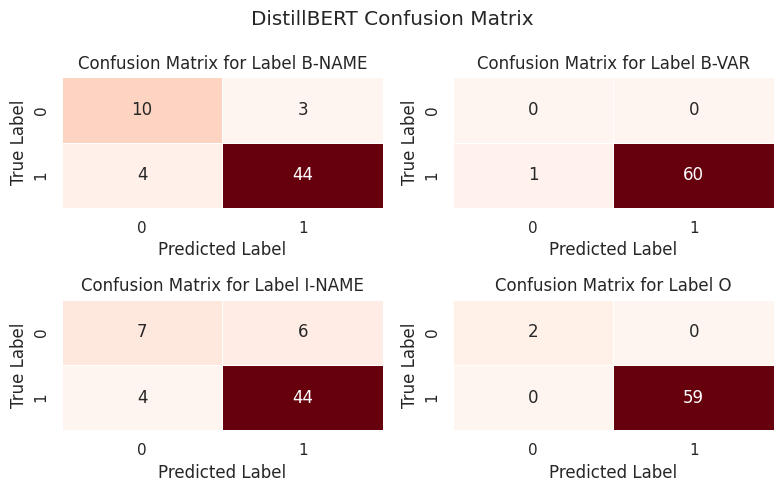

In [191]:
figure_title = "DistillBERT Confusion Matrix"
confusion_matrix(true_labels,true_predictions,figure_title)

In [192]:
text = "the speed f(x)"
tokenizer = DistilBertTokenizer.from_pretrained('taissirboukrouba/my-distillBERT')
classifier = pipeline("ner",model="taissirboukrouba/my-distillBERT",tokenizer=tokenizer)
classifier(text)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CustomDistilBertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

[{'entity': 'B-NAME',
  'score': 0.72729856,
  'index': 1,
  'word': 'the',
  'start': None,
  'end': None},
 {'entity': 'B-VAR',
  'score': 0.92299485,
  'index': 3,
  'word': 'f(x)',
  'start': None,
  'end': None}]

## Visualisation :

In [193]:
trainer.state.log_history[-1]["epoch"]

11.0

In [194]:
for log in trainer.state.log_history :
  if "eval_loss" in log.keys() :
    print(log["eval_loss"])

0.9538134336471558
0.6797541975975037
0.5553905963897705
0.48552942276000977
0.4305912256240845
0.40645644068717957
0.40451136231422424
0.44043248891830444
0.4514448344707489
0.4777476489543915
0.4997795820236206


In [195]:
sns.set_theme()

In [250]:
def plot(metrics,metric_values,plot_labels,xlabel,ylabel,title) :
  values_list = []
  epochs_range = []
  plt.figure(figsize=(10, 5))

  for i in range(len(metric_values)) :
    values_list = [log[metrics[i]] for log in metric_values[i] if metrics[i] in log.keys()]
    epochs_range = range(1,int(metric_values[i][-1]["epoch"])+1)
    sns.lineplot(x = epochs_range, y = values_list, label=plot_labels[i])

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
  plt.grid(True)

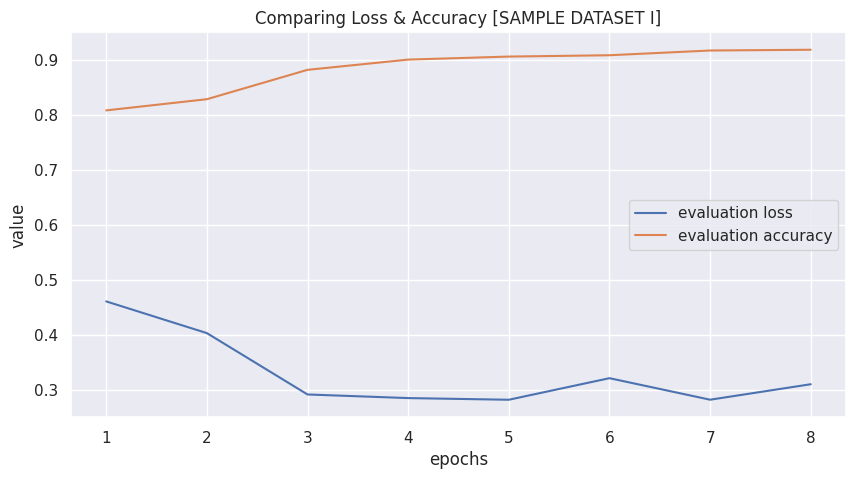

In [256]:
metrics = ["eval_loss", "eval_accuracy"]
metric_values = [trainer.state.log_history]*2
plot_labels = ["evaluation loss","evaluation accuracy"]
ylabel = "value"
xlabel = "epochs"
title = "Comparing Loss & Accuracy [SAMPLE DATASET I]"

plot(metrics,metric_values,plot_labels,xlabel,ylabel,title)

# Model from-scratch :

## Personalized Tokenizer :

In [198]:
class PersonalisedTokenizer:
    def __init__(self, vocab=None):
        # initialising normal vocabulary (used to encode tokens into ids)
        self.vocab = vocab if vocab else {}
        # initialising inverse vocabulary (used to get tokens using ids)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def get_tokens(self, text):
        # applying custom tokenization
        return my_custom_tokenizer(text)

    def get_token_id(self, tokens):
        # getting token id from vocabulary or replacing it by unknown vocabulary when not present
        unknown_token = self.vocab.get('<unk>', 0)
        return [self.vocab.get(token, unknown_token) for token in tokens]

    def decode_id(self, ids):
        # getting token of the id from the reverse vocabulary
        return [self.inv_vocab.get(i, '<unk>') for i in ids]

    def add_tokens(self, new_tokens):
        for token in new_tokens:
            if token not in self.vocab:
                # add token in case not present in the vocabulary
                self.vocab[token] = len(self.vocab)
                # also updting the inverse vocabulary
                self.inv_vocab[len(self.vocab) - 1] = token

    def get_tokens_ids(self, text, max_length=128,existing_tokens=False):
      # if tokens exist don't tokenize them
      if existing_tokens :
        tokens = text
      # if they don't tokenize the text
      else :
        tokens = self.get_tokens(text)
      # adding [CLS] tag to the start of the setence
      tokens.insert(0,"[CLS]")
      # adding [SEP] tag to the end of the setence
      tokens.insert(len(tokens),"[SEP]")
      # getting token ids
      token_ids = self.get_token_id(tokens)
      # applying truncation
      token_ids = token_ids[:max_length]
      # getting the padding left to add
      padding_length = max_length - len(token_ids)
      # applying padding
      token_ids += [0] * padding_length
      return token_ids

    def decode_tokens_ids(self, token_ids):
        # getting tokens from ids using the reverse vocabulary inside "decode_id()"
        tokens = self.decode_id(token_ids)
        return ' '.join(tokens)

    def get_attention_masks(self,tokens_ids,max_length=128) :
        # getting SEP index
        sep_idx = tokens_ids.index(102)
        # slicing the token ids list
        cut_tokens_ids = tokens_ids[:sep_idx+1]
        # applying attention mask
        attention_masks = [1]*(len(cut_tokens_ids))
        # getting the padding left to add
        padding_length = max_length - len(attention_masks)
        # applying padding
        attention_masks += [0] * padding_length
        return attention_masks

    def save_pretrained(self, save_directory):
        # Save the vocabulary to a file
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        vocab_file = os.path.join(save_directory, 'vocab.json')
        with open(vocab_file, 'w') as f:
            json.dump(self.vocab, f)

In [199]:
my_list = [1, 2, 3, 4, 5, 6]
cut_element = 4
index = my_list.index(cut_element+1)
list1 = my_list[:index]
list2 = my_list[index:]
list1

[1, 2, 3, 4]

In [200]:
# Get the BERT vocabulary as a dictionary
vocab = BertTokenizer.from_pretrained('bert-base-uncased').get_vocab()
# testing vocabulary
print(vocab["speed"])

3177


In [201]:
## testing tokenizer
tokenizer_scratch = PersonalisedTokenizer(vocab=vocab)
text = "f(x) is world"
encoded = tokenizer_scratch.get_tokens_ids(text)
print(encoded)

[101, 0, 2003, 2088, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [202]:
text = ["f(x)","is","world"]
encoded = tokenizer_scratch.get_tokens_ids(text,128,True)
print(encoded)

[101, 0, 2003, 2088, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [203]:
attention_msks = tokenizer_scratch.get_attention_masks(encoded)
attention_msks[:10]

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [204]:
def PersonalisedEncoding(example, tokenizer,label2id,max_length=20):
    input_ids = []
    attention_masks = []
    label_ids = []

    # getting attention masks and input ids
    for tokens in example['tokenized_sentence'] :
      input_id = tokenizer.get_tokens_ids(tokens,max_length,existing_tokens=True)
      input_ids.append(input_id)

      attention_mask = tokenizer.get_attention_masks(input_id,max_length)
      attention_masks.append(attention_mask)


    # getting labels ids
    labels = [sublist for sublist in example['labels']]

    for label in labels :
      label_ids.append([label2id[lab] for lab in label])


    for label in label_ids :
      # adding -100 in the begining of label (CLS)
      label.insert(0,-100)
      # adding -100 in the begining of label (SEP)
      label.insert(len(label),-100)
      # applying padding
      label_pad = max_length - len(label)
      label.extend([-100] * label_pad)

    return {
          "labels_ids": label_ids,
          "input_ids" : input_ids,
          "attention_mask" : attention_masks}

### Testing custom Encoding :

In [205]:
example = {
    'tokenized_sentence': [["f(x)","is","a","function"],['f(x)',"is","a","function"]],
    'labels': [['B-VAR', 'O','B-NAME', 'I-NAME'],['B-VAR', 'O','B-NAME', 'I-NAME']]
}

test_df = pd.DataFrame(example)
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['tokenized_sentence', 'labels'],
    num_rows: 2
})

In [206]:
label2id = {'O': 0, 'B-VAR': 1, 'B-NAME': 2, 'I-NAME': 3}
id2label = {v: k for k, v in label2id.items()}
encoded_test_dataset = test_dataset.map(PersonalisedEncoding,batched=True,fn_kwargs={'tokenizer': tokenizer_scratch,"label2id":label2id})
encoded_test_dataset

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Dataset({
    features: ['tokenized_sentence', 'labels', 'labels_ids', 'input_ids', 'attention_mask'],
    num_rows: 2
})

In [207]:
print(encoded_test_dataset["labels_ids"][0])

[-100, 1, 0, 2, 3, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [208]:
# encodings length check
len(encoded_test_dataset[0]["input_ids"]) == len(encoded_test_dataset[0]["attention_mask"])

True

In [209]:
# encodings length check
len(encoded_test_dataset[0]["labels_ids"]) == len(encoded_test_dataset[0]["attention_mask"])

True

### Applying custom Encoding :

In [210]:
dataset = Dataset.from_pandas(df)
arguments = {"tokenizer": tokenizer_scratch,
             "label2id":label2id,
             "max_length": 128}
encoded_dataset_scratch = dataset.map(PersonalisedEncoding,batched=True,fn_kwargs=arguments)
encoded_dataset_scratch

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'vars', 'names', 'tokenized_sentence', 'labels', 'labels_ids', 'input_ids', 'attention_mask'],
    num_rows: 301
})

In [211]:
# Columns to remove
columns_to_remove = ['sentence', 'vars', 'names', 'labels']

# Remove the unnecessary columns
encoded_dataset_scratch = encoded_dataset_scratch.remove_columns(columns_to_remove)

In [212]:
encoded_dataset_scratch

Dataset({
    features: ['tokenized_sentence', 'labels_ids', 'input_ids', 'attention_mask'],
    num_rows: 301
})

## Splitting Data :

In [213]:
split = encoded_dataset_scratch.train_test_split(test_size=0.2, seed=42)

# Creating DatasetDict
dataset_dict_scratch = DatasetDict({
    'train': split['train'],
    'validation': split['test']
})

In [214]:
new_column_names = {'tokenized_sentence': 'sentence', 'labels_ids': 'labels'}
dataset_dict_scratch = dataset_dict_scratch.rename_columns(new_column_names)

In [215]:
dataset_dict_scratch

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 240
    })
    validation: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 61
    })
})

## Personalised Model :

In [216]:
class SeqLabTransformer(nn.Module):
    def __init__(self, vocab_size, model_dim, num_labels, num_heads, num_layers, feedf_dim, max_seq_len=512):
        super(TransformerForSequenceLabeling, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, model_dim))
        encoder_layers = TransformerEncoderLayer(model_dim=model_dim, num_heads=num_heads, feedf_dim=feedf_dim)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.classifier = nn.Linear(model_dim, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # Embedding + Positional Encoding
        embedded = self.embedding(input_ids) + self.positional_encoding[:, :input_ids.size(1)]

        # Transformer Encoder
        transformer_output = self.transformer_encoder(embedded)

        # Classification head
        logits = self.classifier(transformer_output)

        if labels is not None:
            # Compute loss if labels are provided
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            return loss, logits

        return logits

In [217]:
model_scratch = SeqLabTransformer(
    vocab_size=len(tokenizer_scratch.vocab),
    # Hidden size
    model_dim=768,
    # labels count
    num_labels=4,
    # Number of attention heads
    num_heads=8,
    # Number of encoder layers
    num_layers=6,
    # Feedforward dimension
    feedf_dim=2048 )

## Personalized Training :

In [218]:
global true_labels
global true_predictions
true_labels = []
true_predictions = []

In [219]:
seqeval = evaluate.load("seqeval")
label_list = list(label2id.keys())

# defining arguments
save_directory = "./transformer-scratch-1"
lr = 2e-5
epochs = 20
steps = 100
wd = 0.01
log_st = 100
es = "epoch"
ss = "epoch"
per_device_batch = 16

training_args = TrainingArguments(
    output_dir=save_directory,
    learning_rate=lr,
    per_device_train_batch_size=per_device_batch,
    per_device_eval_batch_size=per_device_batch,
    num_train_epochs=epochs,
    logging_steps=steps,
    weight_decay=wd,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.935836,0.000000,0.000000,0.000000,0.610769
2,No log,0.839263,0.166667,0.256881,0.202166,0.652308
3,No log,0.822564,0.151515,0.183486,0.165975,0.641538
4,No log,0.804684,0.104000,0.119266,0.111111,0.652308
5,No log,0.802037,0.232394,0.302752,0.262948,0.661538
6,No log,0.785590,0.164286,0.211009,0.184739,0.664615
7,0.802300,0.774437,0.230769,0.412844,0.296053,0.675385


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.935836,0.000000,0.000000,0.000000,0.610769
2,No log,0.839263,0.166667,0.256881,0.202166,0.652308
3,No log,0.822564,0.151515,0.183486,0.165975,0.641538
4,No log,0.804684,0.104000,0.119266,0.111111,0.652308
5,No log,0.802037,0.232394,0.302752,0.262948,0.661538
6,No log,0.785590,0.164286,0.211009,0.184739,0.664615
7,0.802300,0.774437,0.230769,0.412844,0.296053,0.675385
8,0.802300,0.794256,0.214876,0.238532,0.226087,0.660000
9,0.802300,0.769236,0.212435,0.376147,0.271523,0.666154
10,0.802300,0.768012,0.204545,0.330275,0.252632,0.672308


TrainOutput(global_step=150, training_loss=0.7679004669189453, metrics={'train_runtime': 351.4689, 'train_samples_per_second': 6.828, 'train_steps_per_second': 0.427, 'total_flos': 0.0, 'train_loss': 0.7679004669189453, 'epoch': 10.0})

In [ ]:
scratch_trainer = Trainer(
    model=model_scratch,
    args=training_args,
    train_dataset=dataset_dict_scratch["train"],
    eval_dataset=dataset_dict_scratch["validation"],
    tokenizer=tokenizer_scratch,
    compute_metrics=get_metrics)

# Start training
scratch_trainer.train()

In [220]:
global true_labels
global true_predictions
report = classification_report(true_predictions, true_labels, output_dict=True)
df_report = pd.DataFrame(report)
df_report

,NAME,VAR,micro avg,macro avg,weighted avg
precision,0.0,0.590164,0.330275,0.295082,0.238077
recall,0.0,0.507042,0.204545,0.253521,0.204545
f1-score,0.0,0.545455,0.252632,0.272727,0.220041
support,105.0,71.000000,176.000000,176.000000,176.000000


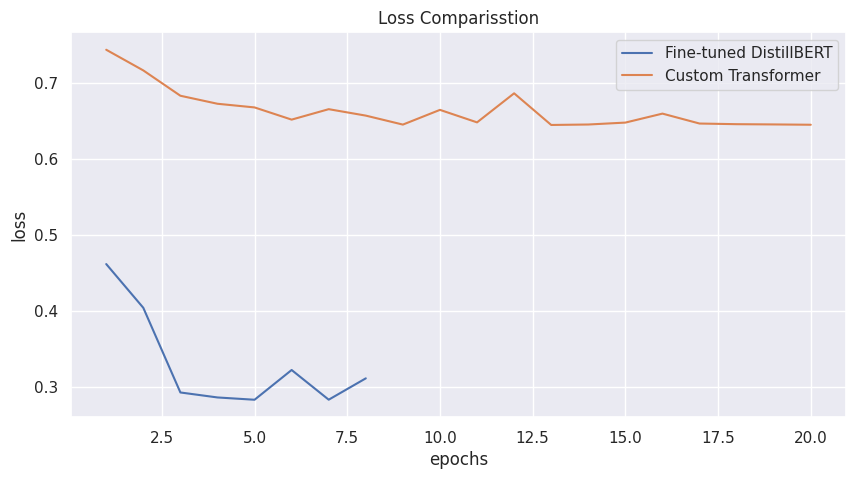

In [254]:
metrics = ["eval_loss"]*2
metric_values = [trainer.state.log_history,scratch_trainer.state.log_history]
plot_labels = ["Fine-tuned DistillBERT","Custom Transformer"]
ylabel = "loss"
xlabel = "epochs"
title = "Loss Comparisstion"

plot(metrics,metric_values,plot_labels,xlabel,ylabel,title)

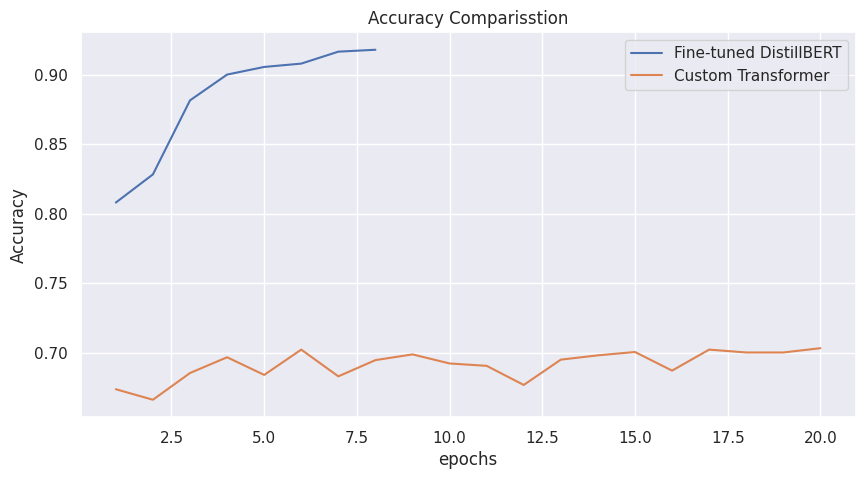

In [255]:
metrics = ["eval_accuracy"]*2
metric_values = [trainer.state.log_history,scratch_trainer.state.log_history]
plot_labels = ["Fine-tuned DistillBERT","Custom Transformer"]
ylabel = "Accuracy"
xlabel = "epochs"
title = "Accuracy Comparisstion"

plot(metrics,metric_values,plot_labels,xlabel,ylabel,title)

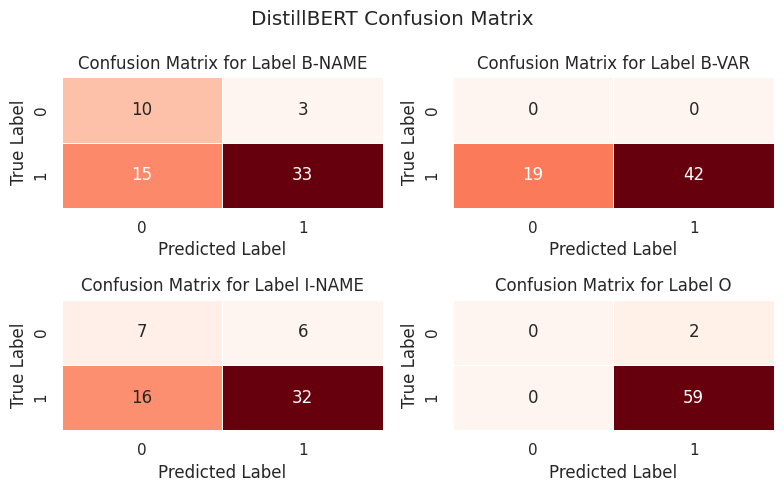

In [224]:
confusion_matrix(true_labels,true_predictions,figure_title)

# Second Data Iteration :

In [225]:
csv = "/content/drive/MyDrive/UH - Final Year Project/data/df-iter-2.csv"
df_iter2 = pd.read_csv(csv)
df_iter2

,sentence,vars,names,variable_position
0,The loading term becomes relevant at a time τ,['τ'],a time,['end']
1,we get easily for the rupture force f ∗,['f'],the rupture force,['end']
2,Green’s theorem can be used to show that the v...,['d3xG(x)'],the volume,['end']
3,at a ﬁxed point x,['x'],['point'],['end']
4,it will be quite small (|K| is large) around t...,['x'],the point,['end']
...,...,...,...,...
2020,on hypercubes of dimension d,['d'],dimension,['end']
2021,The thus computed value τ,['τ'],The thus computed value,['end']
2022,Insights into the structure of a great cluster...,['Mc(s)'],this cluster,['end']
2023,namely the great doubly connected component B,['B'],the great doubly connected component,['end']


In [226]:
df_iter2["variable_position"].value_counts()

,count
variable_position,
['end'],2018
['start'],7


## Modelling Function :

In [227]:
def modelling_pipeline(dataframe,tokenization_func,tokenizer,model,tokenizer_save_dir,mapper,kwargs,finetuned=False) :

  dataframe = preprocessing(dataframe)
  dataframe['tokenized_sentence'] = dataframe['sentence'].apply(tokenization_func)
  dataframe["labels"] = labeling(dataframe)
  if finetuned :
    num_added_tokens = tokenizer.add_tokens(added_tokens)
    model.resize_token_embeddings(len(tokenizer))

  # saving tokenizer
  tokenizer.save_pretrained(tokenizer_save_dir)
  # Convert DataFrame to Dataset
  dataframe = Dataset.from_pandas(dataframe)
  encoded_dataframe = dataframe.map(mapper,batched=True,fn_kwargs=kwargs)
  # Columns to remove
  columns_to_remove = ['sentence', 'vars', 'names', 'labels',"__index_level_0__"]
  # Remove the unnecessary columns
  encoded_dataframe = encoded_dataframe.remove_columns(columns_to_remove)
  # split data
  split = encoded_dataframe.train_test_split(test_size=0.2, seed=42)
  # Creating DatasetDict
  dataset_dict = DatasetDict({
      'train': split['train'],
      'validation': split['test']})

  new_column_names = {'tokenized_sentence': 'sentence', 'labels_ids': 'labels'}
  dataset_dict = dataset_dict.rename_columns(new_column_names)


  return dataset_dict

## Fine-tuned Model Training :

In [228]:
tokenization_func = tokenize
tokenizer = CustomDistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id)
tokenizer_save_dir = "'./finetuned-tokenizer-iter2"
mapper = label_mapper
kwargs = {'tokenizer': tokenizer}

dataset_dict_iter2  = modelling_pipeline(df_iter2,tokenization_func,tokenizer,model,tokenizer_save_dir,mapper,kwargs)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'CustomDistilBertTokenizer'.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1331 [00:00<?, ? examples/s]

In [229]:
dataset_dict_iter2

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1064
    })
    validation: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 267
    })
})

In [230]:
# Train
seqeval = evaluate.load("seqeval")

# defining arguments
save_directory = "./my-distillBERT-iter2"
lr = 2e-5
epochs = 20
steps = 100
wd = 0.01
log_st = 100
es = "epoch"
ss = "epoch"
per_device_batch = 16

# Adding early stopping :
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.01)

# Applying arguments using TrainingArguments API
training_args = TrainingArguments(
    output_dir=save_directory,
    learning_rate=lr,
    per_device_train_batch_size=per_device_batch,
    per_device_eval_batch_size=per_device_batch,
    num_train_epochs=epochs,
    logging_steps=log_st,
    weight_decay=wd,
    eval_strategy=es,
    save_strategy=ss,
    load_best_model_at_end=True,
    push_to_hub=True)

In [231]:
# defining Trainer API
trainer_iter2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict_iter2["train"],
    eval_dataset=dataset_dict_iter2["validation"],
    tokenizer=tokenizer,
    compute_metrics=get_metrics,
    callbacks=[early_stopping_callback])

# training
trainer_iter2.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.461479,0.594150,0.731982,0.655903,0.808116
2,0.658000,0.403936,0.661049,0.795045,0.721881,0.828404
3,0.334400,0.292587,0.710280,0.855856,0.776302,0.881706
4,0.334400,0.286034,0.770161,0.860360,0.812766,0.900275
5,0.193200,0.283014,0.783401,0.871622,0.825160,0.905777
6,0.127200,0.322150,0.774510,0.889640,0.828092,0.908184
7,0.127200,0.283094,0.790224,0.873874,0.829947,0.916781
8,0.091600,0.311170,0.786853,0.889640,0.835095,0.918157


TrainOutput(global_step=536, training_loss=0.2671836823669832, metrics={'train_runtime': 1504.5203, 'train_samples_per_second': 14.144, 'train_steps_per_second': 0.891, 'total_flos': 278039851106304.0, 'train_loss': 0.2671836823669832, 'epoch': 8.0})

In [ ]:
global true_predictions
global true_labels


report = classification_report(true_predictions, true_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

In [ ]:
figure_title = "DistillBERT Confusion Matrix (2nd Data Batch)"
confusion_matrix(true_labels,true_predictions,figure_title)

In [ ]:
text = "the speed f(x)"
tokenizer = DistilBertTokenizer.from_pretrained('taissirboukrouba/my-distillBERT-iter2')
classifier = pipeline("ner",model="taissirboukrouba/my-distillBERT-iter2",tokenizer=tokenizer)
classifier(text)

## Model From Scratch Training :

In [ ]:
tokenization_func = tokenize
tokenizer_save_dir = "'./finetuned-tokenizer-iter2"
mapper = PersonalisedEncoding
kwargs = arguments = {"tokenizer": tokenizer_scratch,"label2id":label2id,"max_length": 128}

dataset_dict_iter2_scratch  = modelling_pipeline(df_iter2,tokenization_func,tokenizer_scratch,model_scratch,tokenizer_save_dir,mapper,kwargs)

In [ ]:
dataset_dict_iter2_scratch

In [ ]:
global true_labels
global true_predictions
true_labels = []
true_predictions = []

In [ ]:
seqeval = evaluate.load("seqeval")
label_list = list(label2id.keys())

# defining arguments
save_directory = "./transformer-scratch-1"
lr = 2e-5
epochs = 20
steps = 100
wd = 0.01
log_st = 100
es = "epoch"
ss = "epoch"
per_device_batch = 16

training_args = TrainingArguments(
    output_dir=save_directory,
    learning_rate=lr,
    per_device_train_batch_size=per_device_batch,
    per_device_eval_batch_size=per_device_batch,
    num_train_epochs=epochs,
    logging_steps=steps,
    weight_decay=wd,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,)

In [ ]:
scratch_trainer_iter2 = Trainer(
    model=model_scratch,
    args=training_args,
    train_dataset=dataset_dict_scratch_iter2["train"],
    eval_dataset=dataset_dict_scratch_iter2["validation"],
    tokenizer=tokenizer_scratch,
    compute_metrics=get_metrics)

# Start training
scratch_trainer_iter2.train()

## Comparison Visualisation :